In [159]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
import mplcyberpunk
import tqdm
#from functions import nth_derivative

In [160]:
plt.style.use('cyberpunk')
#mplcyberpunk.make_lines_glow()

In [161]:
def nth_derivative(net, x:torch.Tensor, j:int, i:int ,n:int) -> torch.Tensor:
    """
    Esta función está creada para regresar la n-derivada de la componente j de la
    función ann respecto de la variable i. 
    
    ann(x)=(ann_0(x), ann_1(x)...,ann_j(x)...).
    
    Con x=(x_0,x_1,...,x_i,...)
    
    x debe ser un tensor: torch.Size([n, m])

    Para el buen funcionamiento: net(x)[0].shape = torch.Size([1])
    """
    x.requires_grad=True
    # Initialize the gradient tensor to 1.0, as the 0th derivative is the function itself.
    ann=net(x)[:,j].view(-1,1)
    grad_tensor = torch.ones(ann.size(), dtype=torch.float32, requires_grad=True)
    for _ in range(n):
        Dann=torch.autograd.grad(ann, x, grad_outputs=grad_tensor, create_graph=True)[0][:,i]
        Dann=Dann.reshape(ann.shape)
        ann=Dann
    return ann

In [162]:
# Definición de la función F(t)
def F(t):
  """
  Función vectorial F(t) = (t^2, 2t).

  Args:
    t: Tensor de PyTorch que representa el tiempo.

  Returns:
    Tensor de PyTorch que representa la función F(t).
  """
  t_squared = torch.pow(t, 2)
  two_t = 2 * t
  return torch.stack((t_squared, two_t), dim=1)

# Ejemplo de uso
t = torch.linspace(0.0, 1.0, 100)
f_t = F(t)

In [163]:
F(torch.tensor([3]))

tensor([[9, 6]])

In [164]:
nth_derivative(F,torch.tensor([[3.0]]), 1, 0,1)

tensor([[2.]], grad_fn=<ReshapeAliasBackward0>)

Lets solve the ODE system: Lotka-Volterra

\begin{split}\begin{aligned}
\frac{dx(t)}{dt} &= \alpha x(t) - \beta x(t)y(t), \quad x\left(0\right) = x_{0} \\
\frac{dy(t)}{dt} &= \delta x(t)y(t) - \gamma y(t), \quad y\left(0\right) = y_{0}.
\end{aligned}\end{split}

with $x(0) = 1.5$, $y(0) = 1.0$

<!-- \begin{align} 
x(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t} \\
y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t}
\end{align} -->

## System of Ordinary Differential Equations
A number of coupled differential equations form a system of equations. Let $t \in \mathcal{R}$ 
be the independent variable and $$\bar{x}(t) : \mathcal{R}\longrightarrow \mathcal{R}^m$$
be a function of $t$. A system of ordinary differential equations of order $n$ takes the form:

$$F(t, \vec{x}, \frac{d\vec{x}}{dt}, \frac{d^2\vec{x}}{dt^2}, \ldots, \frac{d^n\vec{x}}{dt^n}) = \vec{0},
$$

\\


\\


$$
\begin{split}\begin{pmatrix}
f_0(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
f_1(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
\vdots \\
f_{m-1}(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n})
\end{pmatrix}
=
\begin{pmatrix}
0 \\
0 \\
\vdots \\
0
\end{pmatrix}\end{split}
$$

In [165]:
nodos=35
ANN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,2))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=35, bias=True)
  (1): Tanh()
  (2): Linear(in_features=35, out_features=35, bias=True)
  (3): Tanh()
  (4): Linear(in_features=35, out_features=2, bias=True)
)


In [166]:
#The domain and the batch for the training
ti=0.0
tf=10.0

t=torch.linspace(ti,tf,80).view(-1,1)

In [167]:
#reparam of the solution to meet the initial conditions
init_conditions=torch.tensor([[1.5,1.0]])

def Param(t,x0=init_conditions,net=ANN):
    #out = net(T)
    #b=1-torch.exp(ti-T[:,0])
    #return torch.reshape(T[:,1],out.size()) + b*out
    #return T[:,1].view(-1,1) + a.view(-1,1) +b.view(-1,1)**2 * out
    return x0 + (1.0-torch.exp(ti-t))*net(t)
    #return x0 + b.view(-1,1) * out

In [168]:
Param(torch.tensor([0.0]))

tensor([[1.5000, 1.0000]], grad_fn=<AddBackward0>)

In [169]:
nth_derivative(Param,t, 0, 0,2)

tensor([[ 3.1178e-01],
        [ 3.4104e-01],
        [ 3.5433e-01],
        [ 3.5074e-01],
        [ 3.3161e-01],
        [ 3.0035e-01],
        [ 2.6163e-01],
        [ 2.2027e-01],
        [ 1.8029e-01],
        [ 1.4437e-01],
        [ 1.1384e-01],
        [ 8.8904e-02],
        [ 6.9115e-02],
        [ 5.3679e-02],
        [ 4.1738e-02],
        [ 3.2508e-02],
        [ 2.5342e-02],
        [ 1.9738e-02],
        [ 1.5322e-02],
        [ 1.1816e-02],
        [ 9.0185e-03],
        [ 6.7808e-03],
        [ 4.9907e-03],
        [ 3.5621e-03],
        [ 2.4276e-03],
        [ 1.5328e-03],
        [ 8.3367e-04],
        [ 2.9367e-04],
        [-1.1756e-04],
        [-4.2533e-04],
        [-6.5079e-04],
        [-8.1157e-04],
        [-9.2220e-04],
        [-9.9468e-04],
        [-1.0388e-03],
        [-1.0625e-03],
        [-1.0719e-03],
        [-1.0722e-03],
        [-1.0669e-03],
        [-1.0591e-03],
        [-1.0509e-03],
        [-1.0437e-03],
        [-1.0386e-03],
        [-1


\begin{split}\begin{aligned}
\frac{dx(t)}{dt} &= \alpha x(t) - \beta x(t)y(t), \quad x\left(0\right) = x_{0} \\
\frac{dy(t)}{dt} &= \delta x(t)y(t) - \gamma y(t), \quad y\left(0\right) = y_{0}.
\end{aligned}\end{split}

with $x(0) = 1.5$, $y(0) = 1.0$

In [170]:
# def cost(t):
#     x=Param(t)[:,0].view(-1,1)5.0
#     y=Param(t)[:,1].view(-1,1)
#     Dt_x = nth_derivative(Param,t, 0, 0,1)
#     Dt_y = nth_derivative(Param,t, 1, 0,1)No hay un huesito por ahí?
    
#     #x0=ANN(torch.tensor([[0.0]]))+torch.tensor([[1.5,1.0]])

#     return torch.linalg.norm(Dt_x - x + x*y)**2 + torch.linalg.norm(Dt_y - x*y +y)**2 #+ torch.linalg.norm(x0)**2

def cost(t):
    x=Param(t)[:,0].view(-1,1)
    y=Param(t)[:,1].view(-1,1)
    Dt_x = nth_derivative(Param,t, 0, 0,1)
    Dt_y = nth_derivative(Param,t, 1, 0,1)
    #x0=ANN(torch.tensor([0])-torch.zeros_like(t))
    return torch.linalg.norm(Dt_x - 5)**2 + torch.linalg.norm(-Dt_y - torch.cos(x))**2


    #return torch.linalg.norm(Dt_x + x - x*y)**2 + torch.linalg.norm(Dt_y - x*y +y)**2 #+ torch.linalg.norm(ANN(torch.tensor([0.0]))-torch.ones_like(t))


In [171]:
cost(t)

tensor(2017.8138, grad_fn=<AddBackward0>)

In [172]:
learning_rate=0.01
epocas=1000

optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate, weight_decay=0.1)


Training: 100%|█████████████████████████████████████| 1000/1000 [00:12<00:00, 78.39it/s, loss=0.869]


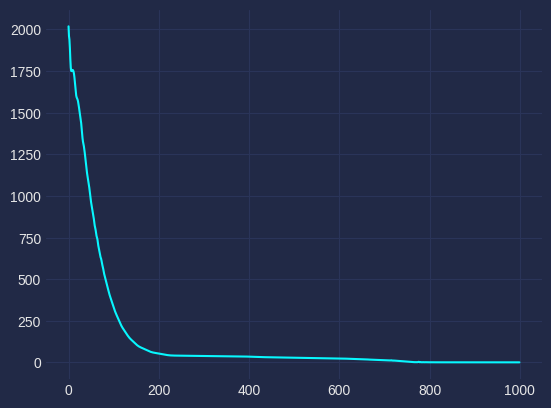

In [173]:
#loop de entrenamiendo 
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(t) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)

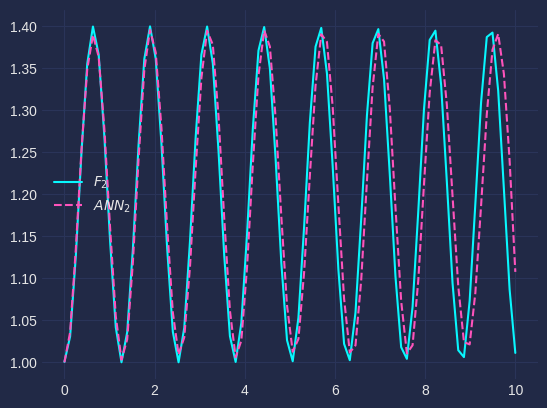

In [178]:
# plt.plot(t.detach(), 5.0/2.0*t.detach()**2+1.5, label='$F_1$')
plt.plot(t.detach(), -1.0/5.0*np.sin(5.0*t.detach()+1.5)+1.2, label='$F_2$')

#plt.plot(t.detach(),Param(t).detach()[:,0],'--', label='$ANN_1$')
plt.plot(t.detach(),Param(t).detach()[:,1],'--', label='$ANN_2$')

plt.legend()
#plt.plot(t.detach(),1/3 * torch.exp(t.detach()) + 2/3*torch.exp(4.0*t.detach()))
         
#y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t})

In [175]:
Param(torch.tensor([0.0]))

tensor([[1.5000, 1.0000]], grad_fn=<AddBackward0>)

In [176]:
torch.linalg.norm(ANN(torch.tensor([0.0]))-torch.tensor([[1.5,1.0]]))**2

tensor(12.5501, grad_fn=<PowBackward0>)

In [177]:
# Parámetros del modelo
a = 1.0
b = 1.0
c = 1.0
d = 1.0

# Ecuaciones de Lotka-Volterra
def dxdt(x, y):
  return a * x - b * x * y

def dydt(x, y):
  return c * x * y - d * y

# Solución numérica de las ecuaciones
t0 = np.linspace(0,10, 100)
x0 = np.zeros(len(t0))
y0 = np.zeros(len(t0))

x0[0] = 1.5
y0[0] = 1.0

for i in range(1, len(t0)):
  x0[i] = x0[i - 1] + dxdt(x[i - 1], y0[i - 1]) * (t0[i] - t0[i - 1])
  y0[i] = y0[i - 1] + dydt(x[i - 1], y0[i - 1]) * (t0[i] - t0[i - 1])

# Gráfica de las poblaciones
plt.plot(t0, x0, label="Presa")
plt.plot(t0, y0, label="Depredador")
plt.xlabel("Tiempo")
plt.ylabel("Población")
plt.legend()
plt.show()

NameError: name 'x' is not defined